#### NLP | Model

# Coronavirus Tweets: April 2020<a id='top'></a> 

### Natural Language Processing Stepwise Analysis<a id='top'></a> 

1. [Research Question](#1)<br/>
2. [DataFrames](#2) <br/>
3. [Exploratory Data Analysis](#3)<br/>
   [Data Summary](#31)<br/>
4. [Preprocessing](#4)<br/>
   [Clean Text](#41)<br/>
   [Stop Words](#42)<br/>
   [Stemming](#43)<br/>
5. [Vectorizer](#5)<br/>
6. [Topic Modeling/Dimensionality Reduction](#6)<br/>
7. [Sentiment Analysis](#7)<br/>
8. [Classification](#8) <br/>
    1 [Naive Bayes: Gaussian](#81)<br/>
    2 [Naive Bayes: Multinomial](#81)<br/>
9. [Data Visualization](#9)<br/>  

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pickle
import re
import spacy
import en_core_web_sm
import string
pd.set_option('display.max_colwidth', None)

from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag #?
from nltk.tokenize import word_tokenize #?
from nltk.util import ngrams #?
from sklearn.decomposition import PCA, NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
from wordcloud import WordCloud, STOPWORDS


# 1 | Research Design<a id='1'></a> 

* **Research Question:** What were Americans tweeting about coronavirus and COVID-19 in April 2020? 
* **Impact Hypothesis:** Inform CDC's communication strategy for future pandemics. 
* **Data source:** Coronavirus COVID-19 Tweets [early](https://www.kaggle.com/datasets/smid80/coronavirus-covid19-tweets-early-april) and [late](https://www.kaggle.com/datasets/smid80/coronavirus-covid19-tweets-late-april) April, n=138,796


[back to top](#top)

# 2 | [DataFrames](https://github.com/slp22/nlp-project/blob/main/nlp-coronavirus-tweets-mvp.ipynb)<a id='2'></a> 

In [2]:
# load tweets selected for mvp 
tweets_df = pd.read_csv('./raw_data/tweet_df.csv', low_memory=False)


In [109]:
tweets_df.iloc[75003]

created_at                                                                                                                                                                                                                                                                                                 2020-04-16T05:27:23Z
screen_name                                                                                                                                                                                                                                                                                                          RRancheria
text            The #ReddingRancheria and @WRResortCasino are lit to honor medical and essential employees as part of the national #LightItBlue campaign. Keep social distancing guidelines in place and be safe #Thankyou to all who keep our Community safe #CoronavirusOutbreak  #wereinthistogether https://t.co/kztwA8shXR
country_code                            

[back to top](#top)

# 3 | Exploratory Data Analysis<a id='3'></a> 

##### Note: Full EDA part of [MVP](https://github.com/slp22/nlp-project/blob/main/nlp-coronavirus-tweets-mvp.ipynb).

### Data Summary<a id='31'></a> 

In [4]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138796 entries, 0 to 138795
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   created_at    138796 non-null  object
 1   screen_name   138790 non-null  object
 2   text          138789 non-null  object
 3   country_code  138789 non-null  object
 4   account_lang  2 non-null       object
 5   verified      138787 non-null  object
 6   lang          138787 non-null  object
dtypes: object(7)
memory usage: 7.4+ MB


#### All data types are objects. The column `account_lang` is mostly null values, will drop in next step. 

[back to top](#top)

## 4 | Preprocessing<a id='4'></a>  

In [5]:
# isolate text, drop other columns
# save as text_df

text_df = tweets_df.drop(columns=['created_at', 
                                  'screen_name', 
                                  'country_code',
                                  'account_lang', 
                                  'verified', 
                                  'lang'])
print(type(text_df))
text_df.head(2)


<class 'pandas.core.frame.DataFrame'>


,text
0,....#SUNDAYFUNDAY #coronavirus style #vino cheers 🍷 https://t.co/SrymChBkq2
1,"This pandemic has confirmed my worst fears, most people don’t know how to make entertaining videos. #Covid_19 #SinceIveBeenQuarantined #AmericasUnfunniestVideos #WrestleMania #tonyaharding"


### 4.1 Text Cleaning  <a id='41'></a>  

In [6]:
# remove numbers, punctuation, and capital letters
alphanumeric = lambda x: re.sub('\w*\d\w*',' ', str(x))
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
                          
text_df['text'] = text_df.text.map(alphanumeric).map(punc_lower)
text_df.head(2)


,text
0,sundayfunday coronavirus style vino cheers 🍷 https t co
1,this pandemic has confirmed my worst fears most people don’t know how to make entertaining videos sinceivebeenquarantined americasunfunniestvideos wrestlemania tonyaharding


In [7]:
# remove emojis
text_df = text_df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))


In [71]:
# remove https t co
link = lambda x: re.sub('https', ' ', str(x))
t_co = lambda x: re.sub('t co', ' ', str(x))

text_df['text'] = text_df.text.map(link).map(t_co)

In [72]:
text_df.head(10)


,text,compound_score,sentiment
0,sundayfunday coronavirus style vino cheers,0.4767,positive
1,this pandemic has confirmed my worst fears most people dont know how to make entertaining videos sinceivebeenquarantined americasunfunniestvideos wrestlemania tonyaharding,-0.6124,negative
2,is this true \n \n ecuadorenemergencia coronaviruspandemic,0.4215,positive
3,many us thought it was wuhan province but i uld never be us then it was italy but i uld never be us now it is here one newyorker died every minutes from over this weekend absolutely devastating \n\n,-0.9230,negative
4,ah coronavirus humor,0.2732,positive
5,miami and south florida in general are also staying home \n\nnorth florida thinks their immune to oipfvqymvc,0.2960,positive
6,how can president trump be flip about a question abou ntinuity of power and contracting the coronavirus when i am around him i dont breathe and we wonder why other americans question and defy the quarantine coronavirustaskforce,0.0000,positive
7,this is our most desperate hour help us obi wan kenobi you re our only hope starwars weneedaleader,0.5058,positive
8,face your fears \n business love coronavirus nyc ny la california zoom happy prayer,0.7269,positive
9,first defense nasal screen coming up on abcsharktank during the outbreak and all of a sudden the guy doesnt seem crazy \n\nsharks redeemed themselves w mega offers \n\npos rona airing mcuban thesharkdaymond kevinolearytv is gonna make a killing replaces mask need,-0.1441,negative


In [9]:
text_df.tail(10)


,text
138786,the nfl draft is here this is something everyone needs right now to get everyones mind off of the coronoavirus
138787,so has now shifted from untested medication to telling us that maybe injecting disinfectant or somehow getting uv rays inside our bodies will cure the virus so tide pods are next coronavirus trumppressconference trumpisanidiot trumppressbriefing https t co wgavormglv
138788,discussing with my dad told him what i learned about typhoidmary on myfavmurder he said he was proud my obsession is helping me deal with my anxiety in regards to our newnormal karenkilgariff ghardstark ssdgm
138789,talkingtaiwan guest emily chen talked about how she manages having her kids at home during this coronavirus pandemic listen until the end for a special offering https t co coronavirus coronavirusoutbreak homeschool coronavirus interview emily chen
138790,report state dept confirms china iran and russia are working together to blame us for https t co
138791,we are thankful triadcleanhome thankful thankfulthursday americaworkstogether smallbusiness community communitylove shoplocal shopsmall highpointnc piedmonttriad triadnc thankyou pandemic humble commercialcleaning smallbusinessowner https t co fjimozmxzo
138792,covidart mixedmedia sheep cartoon diary sketchbookjournal sketchbook coronavirus uncertainty hermit isolation flattenthecurve stopthespread sunshine practice sparetire san diego california https t co
138793,sitting in the office after another hour day and feeling thankful for all those who are sharing life friendship and leadership with me during this crazy time in history friends workfamily leadership
138794,realdonaldtrump ondinebio has been using light to kill viruses and mrsa for years testing happening now in canada solution ready now
138795,starting in just a moment live on facebook or on wxxi tv am follow us here for live updates forum https t co


[back to top](#top)

In [10]:
# save preprocessed tweets as corpus_df
corpus_df = text_df
corpus_df.to_pickle('./raw_data/corpus_df.pkl')
corpus_df.to_csv(r'//Users/sandraparedes/Documents/GitHub/metis_dsml/05_nlp/g00-nlp-project/raw_data/corpus_df.csv', index=False)


### 4.2 Stop Words  <a id='42'></a>  

In [79]:
# custom stop words 
stopwords = nltk.corpus.stopwords.words('english')
new_words = ['also',
             'amp', 
             'corona', 
             'coronavirus',
             'one',
             'today',
             'need',
             'people',
             'us',
             'pandemic', 
             'covid',
             'pandemic',
             'day',
             'coronaviruspandemic',
             'get',
             'like',
             'time',
            'im',
            'go']
stopwords.extend(new_words)
print(stopwords)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[back to top](#top)

### 4.3 Stemming  <a id='43'></a>  

In [80]:
# stemmer
stemmer = SnowballStemmer("english")

def prep(word):
    if word in stopwords:
        return None
    elif stemmer is None:
        return word
    else:
        return stemmer.stem(word)


[back to top](#top)

## 5 | Vectorizer<a id='5'></a>  

In [81]:
# load preprocessed corpus from step 3 
df = pd.read_pickle("./raw_data/corpus_df.pkl")  
df.head(2)

,text
0,sundayfunday coronavirus style vino cheers https t co
1,this pandemic has confirmed my worst fears most people dont know how to make entertaining videos sinceivebeenquarantined americasunfunniestvideos wrestlemania tonyaharding


In [82]:
corpus = df.text
print('corpus type:', type(corpus))
print(corpus.head(2))

corpus type: <class 'pandas.core.series.Series'>
0                                                                                                                            sundayfunday  coronavirus style  vino cheers  https   t co  
1    this pandemic has confirmed my worst fears  most people dont know how to make entertaining videos      sinceivebeenquarantined  americasunfunniestvideos  wrestlemania  tonyaharding
Name: text, dtype: object


### Term Frequency Inverse Document Frequency (TF-IDF)

In [83]:
tf_vectorizer = TfidfVectorizer(stop_words=stopwords, 
                                min_df=0.01, 
                                max_df=.95, 
                                preprocessor=prep)
tf_vectorizer

TfidfVectorizer(max_df=0.95, min_df=0.01,
                preprocessor=<function prep at 0x7f96649e8940>,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [84]:
# document-term matrix with TF-IDF
tf_doc_term_mtx = tf_vectorizer.fit_transform(corpus)
type(tf_doc_term_mtx)

scipy.sparse._csr.csr_matrix

In [85]:
tf_doc_term_df = pd.DataFrame(tf_doc_term_mtx.toarray(), 
                              columns=tf_vectorizer.get_feature_names_out())
tf_doc_term_df.head(2)

,america,americans,another,anyone,april,around,away,back,best,better,...,week,weeks,well,work,workers,working,world,would,year,york
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
# double check that domain specfic words were omitted 
print('https' in tf_vectorizer.get_feature_names_out())
print('corona' in tf_vectorizer.get_feature_names_out())
print('covid' in tf_vectorizer.get_feature_names_out())
print('t' in tf_vectorizer.get_feature_names_out())
print('amp' in tf_vectorizer.get_feature_names_out())


True
False
False
False
False


[back to top](#top)

## 6 | Topic Modeling/Dimensionality Reduction <a id='6'></a>  

### Non-Negative Matrix Factorization (NMF)

In [87]:
# V     visible variables     doc_term             input (corpus matrix)
# W     weights               doc_topic            feature set
# H     hidden variables      topic_term           coefficients

In [88]:
V = tf_doc_term_mtx
V.shape


(138796, 165)

In [89]:
# W matrix = feature set & weights

nmf = NMF(n_components=3, init=None)
W = nmf.fit_transform(V).round(3)
print(type(W))
W.shape

<class 'numpy.ndarray'>


(138796, 3)

In [90]:
# H matrix = hidden variables & coefficients 

H = pd.DataFrame(nmf.components_.round(2),
                 index = ['c1', 
                          'c2',
                          'c3'] #,
#                           'c4']#,, 
#                           'c5']
                 ,
                 columns = tf_vectorizer.get_feature_names_out())
print('H.shape:',  H.shape)
H.T.style.background_gradient(cmap='Blues')


H.shape: (3, 165)


,c1,c2,c3
america,0.020000,0.310000,0.000000
americans,0.000000,0.410000,0.000000
another,0.060000,0.280000,0.050000
anyone,0.000000,0.360000,0.030000
april,0.060000,0.290000,0.020000
around,0.030000,0.290000,0.020000
away,0.010000,0.270000,0.030000
back,0.000000,0.830000,0.060000
best,0.040000,0.270000,0.060000
better,0.020000,0.340000,0.030000


[back to top](#top)

In [91]:
# function to display topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))


#### Top terms by topic:

In [92]:
display_topics(nmf, tf_vectorizer.get_feature_names_out(), 10)


Topic  0
co, https, via, socialdistancing, stayhome, thank, california, great, stayhomestaysafe, join

Topic  1
new, trump, realdonaldtrump, home, cases, stay, help, know, thank, deaths

Topic  2
quarantine, stayhome, quarantinelife, socialdistancing, stayathome, staysafe, lockdown, california, home, stay


   [Stop Words](#42)<br/>


[back to top](#top)

## 7 | Sentiment Analysis<a id='7'></a>  

### Vader Sentiment

In [93]:
analyzer = SentimentIntensityAnalyzer() 
sentiment = analyzer.polarity_scores(text_df).get('compound')
print('compound_score', sentiment)

compound_score 0.0


In [94]:
text_df['compound_score'] = text_df.text.map(analyzer.polarity_scores).map(lambda x: x.get('compound'))
text_df.head(15)


,text,compound_score,sentiment
0,sundayfunday coronavirus style vino cheers,0.4767,positive
1,this pandemic has confirmed my worst fears most people dont know how to make entertaining videos sinceivebeenquarantined americasunfunniestvideos wrestlemania tonyaharding,-0.6124,negative
2,is this true \n \n ecuadorenemergencia coronaviruspandemic,0.4215,positive
3,many us thought it was wuhan province but i uld never be us then it was italy but i uld never be us now it is here one newyorker died every minutes from over this weekend absolutely devastating \n\n,-0.9230,negative
4,ah coronavirus humor,0.2732,positive
5,miami and south florida in general are also staying home \n\nnorth florida thinks their immune to oipfvqymvc,0.2960,positive
6,how can president trump be flip about a question abou ntinuity of power and contracting the coronavirus when i am around him i dont breathe and we wonder why other americans question and defy the quarantine coronavirustaskforce,0.0000,positive
7,this is our most desperate hour help us obi wan kenobi you re our only hope starwars weneedaleader,0.5058,positive
8,face your fears \n business love coronavirus nyc ny la california zoom happy prayer,0.7269,positive
9,first defense nasal screen coming up on abcsharktank during the outbreak and all of a sudden the guy doesnt seem crazy \n\nsharks redeemed themselves w mega offers \n\npos rona airing mcuban thesharkdaymond kevinolearytv is gonna make a killing replaces mask need,-0.1441,negative


In [95]:
# map sentiment column to positive or negative based on compound score
text_df['sentiment'] = text_df['compound_score'].apply(lambda x: 'positive' if x >=0 else 'negative')
text_df.head(2)

,text,compound_score,sentiment
0,sundayfunday coronavirus style vino cheers,0.4767,positive
1,this pandemic has confirmed my worst fears most people dont know how to make entertaining videos sinceivebeenquarantined americasunfunniestvideos wrestlemania tonyaharding,-0.6124,negative


[back to top](#top)

## 8 | Classification<a id='8'></a>  

### Can a NaiveBayes model predict the sentiment of the tweet?

In [96]:
# split feature and target
X = text_df.text
y = text_df.sentiment

# split train/test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42)

# fit/transform to TF-IDF vectorizer from step 5
X_train_tf = tf_vectorizer.fit_transform(X_train)
X_test_tf  = tf_vectorizer.transform(X_test)


In [97]:
tfidf = pd.DataFrame(X_train_tf.toarray(), columns=tf_vectorizer.get_feature_names_out())
tfidf.head(2)

,america,americans,another,anyone,april,around,back,best,better,business,...,week,weeks,well,work,workers,working,world,would,year,york
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### 8.1 Naive Bayes: Gaussian<a id='81'></a> 

In [98]:
gaus = GaussianNB()
gaus.fit(X_train_tf.toarray(), y_train)
sentiment_score = gaus.score(X_test_tf.toarray(), y_test)
sentiment_score

0.6023679723336295

[back to top](#top)

### 8.2 Naive Bayes: Multinomial<a id='82'></a> 

In [99]:
multi = MultinomialNB()
multi.fit(X_train_tf.toarray(), y_train)
sentiment_score = multi.score(X_test_tf.toarray(), y_test)

sentiment_score

0.7348159177693989

[back to top](#top)

## 9 | Data Visualization <a id='9'></a>  

Code thanks to [geeksforgeeks](https://www.geeksforgeeks.org/generating-word-cloud-python/)


In [100]:
# df = pd.read_csv('./raw_data/corpus_df.csv')


In [101]:
# # custom stop words 
# stopwords = nltk.corpus.stopwords.words('english')
# new_words = ['also',
#              'amp', 
#              'corona', 
#              'coronavirus', 
#              'https',
#              't',
#              'co',
#              'people',
#              'us',
#              'pandemic', 
#              'covid',
#              'pandemic',
#              'day',
#              'coronaviruspandemic',
#              'get',
#              'like',
#             'im',
#             'go']
# stopwords.extend(new_words)
# # print(stopwords)

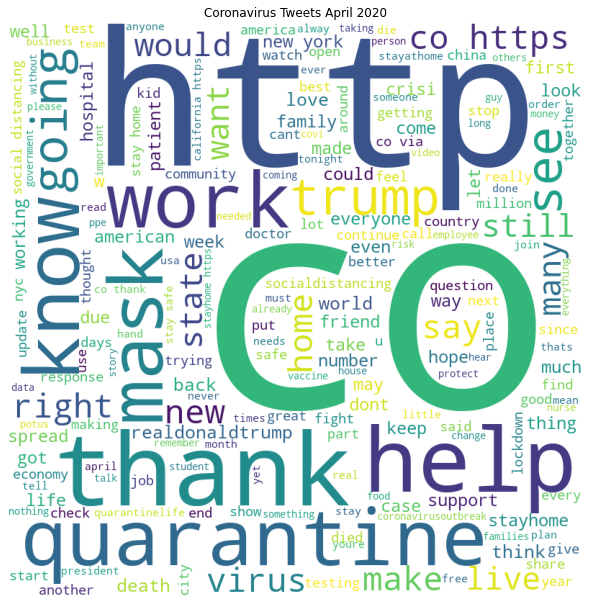

In [102]:
comment_words = ''
stopwords = set(stopwords)
 
# iterate through the csv file
for val in df.text:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Coronavirus Tweets April 2020')
plt.savefig("coronavirus-tweets-word-cloud.jpeg");

#### [comment ]

[back to top](#top)

[back to top](#top)

[back to top](#top)